Short Example for use of propagator.py functions to generate JSA for a single pass poled crystal

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from NeedALight.propagator import Hprop, Total_prog, JSA
from custom_poling.core.target import Target
from custom_poling.core.custom_crystal import CustomCrystal
from tqdm import tqdm
%config InlineBackend.figure_formats=['svg']

This section introduces all relevant quantities needed to use the functions and generate the wanted properties.

In [2]:
#Parameters for calculations

N = 501  # Number of frequency values: Always choose a number ending in 1. That way you always have a frequency value = 0
Np = 2.2 # Number of pump photons: Vary this to modify gain values
vp = 0.1  # pump velocity
l = 1.0  # amplification region length
sig = 1  # pump wave packet spread
a = 1.61 / 1.13  # from symmetric grp vel matching

#Ensuring that we are in the symmetric velocity group matching regime.
def symmetric_v(vp, sig, l, a):
    vi = vp / (1 - 2 * a * vp / (l * sig))
    vs = vp / (1 + 2 * a * vp / (l * sig))
    return vs, vi

vs, vi = symmetric_v(vp, sig, l, a)

#Frequency values
wi = -10
wf = 10
dw = (wf - wi) / (N - 1)
x = np.linspace(wi, wf, N)

#Defining gaussian pump pulse
def pump(x, scale=1):
    return np.exp(-((x) ** 2) / (2 * (sig*scale) ** 2)) / np.power(np.pi * (sig*scale), 1 / 4)



# Crystal properties
Ndomain = 1000
dz = l / Ndomain
domain_width = dz
number_domains = Ndomain
L = number_domains * domain_width
k0 = np.pi / domain_width

# Numerical integration parameters for generating domain
k_range = 100/L
dk = k_range/401
k_array = np.arange(k0-k_range/2,k0+k_range/2,dk)



Here we generate the wanted crystal with the proper domain. The domain will produce a gaussian phase-matching function. We use the code and follow the examples of Agata Branczyk: https://github.com/abranczyk/custom-poling

In [3]:
# Create a custom crystal object
custom_crystal_gauss = CustomCrystal(domain_width,number_domains)
domain_middles_gauss = custom_crystal_gauss.domain_middles

#Define and plot the target function
std = 10
height = 0.025
target_pmf_gauss = lambda k:1j*height*np.exp(-(k-k0)**2/(2*std**2))*np.exp(1j * L/2 * k)
target_gauss = Target(target_pmf_gauss,k_array)

# Compute and plot the target amplitude
target_amplitude_gauss = target_gauss.compute_amplitude(k0,domain_middles_gauss)

# Compute and plot the custom domains
custom_domains_gauss = custom_crystal_gauss.compute_domains(target_amplitude_gauss,k0)
domain = custom_domains_gauss * np.asarray([1, -1] * int(Ndomain / 2)+[1]) #The multiplication here sets the central frequency to 0


#Proper scale factor so that Gaussian PMF and Gaussian Pump have the same width
sc=std/(2*a)

For the single pass structure, we can simply make use of all of the functions to generate all the desired/relevant quantities. The JSA function will give us the JSA, the Schmidt number, as well as all the relevant moments. WE also implicitely remove free propagation phases in the functions.We plot the JSA as well.

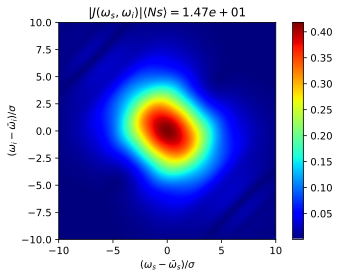

1.0209378356901255


In [4]:
#Generating the JSA
pumpscaled=lambda x: pump(x, scale=sc) #Scale is modified with poling, defined in the previous block
prod1, P1, Nm1  = Hprop(Np, vs, vi, vp, dz, x, pumpscaled,4)  #This generates heisenberg propagators with different signs for length "dz", as well as all possible products of sets of 4 propagators 
T1 = Total_prog(domain, prod1, P1, Nm1) #This generates the total propagator given a specific domain.
J, Ns, K, M, Nums, Numi = JSA(T1, vs, vi, vp, len(domain) * dz, x) #Generates the JSA as well as other relevant properties.

#Generating plot of JSA
fig, ax = plt.subplots()
im = ax.imshow(J, cmap="jet", origin="lower",extent=[x[0],x[N-1],x[0],x[N-1]])
ax.set_xlabel(r"$(\omega_{s}-\bar{\omega}_{s})/\sigma$")
ax.set_ylabel(r"$(\omega_{i}-\bar{\omega}_{i})/\sigma$")
ax.set_title(r"$|J(\omega_{s}, \omega_{i})|    \langle Ns \rangle = %1.2e $" %Ns)
plt.colorbar(im, orientation="vertical")
plt.show()

print(K)

We obtain the Schmidt modes from the N matrix and plot the first relevant mode. Note that we multiply by a phase factor such that the imaginary part is 0 at the origin.

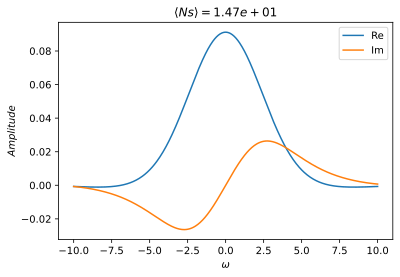

In [5]:
#Looking at the temporal modes via Nums matrix
mark=1 #this just takes the first eigenmode of interest. Choose a different value to look at different ones.
val, u = np.linalg.eigh(Nums)

fig, ax1 = plt.subplots()

ax1.plot(x, np.real(np.exp(-1j*np.angle(u[(N-1)//2,-mark]))*u[:,-mark]), label='Re') #Here we multiply by a phase factor such that the imaginary part is 0 at the origin.
ax1.plot(x, np.imag(np.exp(-1j*np.angle(u[(N-1)//2,-mark]))*u[:,-mark]), label='Im')
ax1.set_xlabel(r"$\omega$")
ax1.set_ylabel(r"$Amplitude$")
ax1.set_title(r"$\langle Ns \rangle= %1.2e$" %Ns)
ax1.legend()

plt.show()

Here we calculate the fidelity/overlap between a fixed low-gain Schmidt mode and another one with variable gain. We loop over different pump strengths.

100%|███████████████████████████████████████████| 15/15 [06:22<00:00, 25.48s/it]


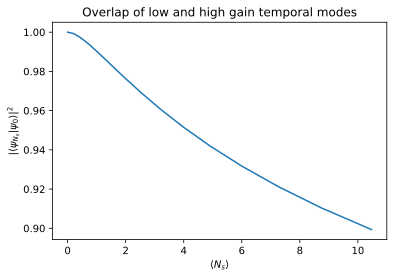

In [6]:
#Overlaps and Schmidt number as a function of Np without Filtering
npi = 0.00024
npf = 2.068
nstep = 15
step = (npf - npi)/nstep
num_pump = np.arange(npi,npf,step)
nsv = np.zeros_like(num_pump)
K = np.zeros_like(num_pump)
Temp_mode = np.zeros([len(x), len(num_pump)],dtype= np.complex128)
overlap = np.zeros(len(num_pump))


for i in tqdm(range(np.size(num_pump))):   
    prod1, P1, Nm1  = Hprop(num_pump[i], vs, vi, vp, dz, x, pumpscaled,4)
    T1 = Total_prog(domain, prod1, P1, Nm1)
    J, Ns, Ks, M, Nums, Numi = JSA(T1, vs, vi, vp, len(domain) * dz, x)

    K[i] = Ks
    nsv[i] = Ns

    w, v = np.linalg.eigh(Nums)
    Temp_mode[:,i] = v[:,-1]
overlapmat = np.abs(np.conj(Temp_mode).T @ Temp_mode) ** 2 #Matrix of all possible overlaps between states at different gains
overlap[:] = overlapmat[0,:] #Overlaps between fixed low level mode and all higher gain modes

#Plots the overlaps as a function of Ns
fig, ax = plt.subplots()
ax.plot(nsv, overlap)
ax.set_xlabel(r"$\langle N_{s} \rangle$")
ax.set_ylabel(r"$\left| \langle  \psi_{N_{s}}  | \psi_{0}   \rangle \right|^{2}$")
ax.set_title("Overlap of low and high gain temporal modes")
plt.show()


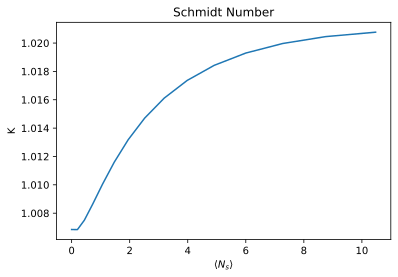

In [7]:
#Plots the Schmidt number as a function of Ns
fig2, ax2 = plt.subplots()
ax2.plot(nsv, K)
ax2.set_xlabel(r"$\langle N_{s} \rangle$")
ax2.set_ylabel("K")
ax2.set_title("Schmidt Number")
plt.show()

Here we consider how filtering affects the fidelity and purity of the state. Note that we are not refering to spectral purity here, but actually the purity of the density matrix. We loop over different pump brightnesses as well as different filter widths. We begin with the Fidelity.

In [8]:
#Filtering effect on Distinguishability: Overlaps for different filters
npi = 0.00024
npf = 2.068
nstep = 15
step = (npf - npi)/nstep

num_pump = np.arange(npi,npf,step)
nsv = np.zeros_like(num_pump)
Temp_mode = np.zeros([len(x), len(num_pump)],dtype= np.complex128)
overlap = np.zeros([len(num_pump),6])


#No filtering
for i in tqdm(range(np.size(num_pump))):   
    prod1, P1, Nm1  = Hprop(num_pump[i], vs, vi, vp, dz, x, pumpscaled,4)
    T1 = Total_prog(domain, prod1, P1, Nm1)
    J, Ns, Ks, M, Nums, Numi = JSA(T1, vs, vi, vp, len(domain) * dz, x)

    nsv[i] = Ns

    w, v = np.linalg.eigh(Nums)
    Temp_mode[:,i] = v[:,-1]
overlapmat = np.abs(np.conj(Temp_mode).T @ Temp_mode) ** 2
overlap[:,0] = overlapmat[0,:]

#Overlaps for Different Filter Widths
for j in range(5):
    index = 30 + 50 * j
    filt=np.zeros_like(x)
    filt[index:-index]=1
    filt = np.diag(filt)
    for i in range(np.size(num_pump)):   
        prod1, P1, Nm1  = Hprop(num_pump[i], vs, vi, vp, dz, x, pumpscaled,4)
        T1 = Total_prog(domain, prod1, P1, Nm1)
        J, Ns, Ks, M, Nums, Numi = JSA(T1, vs, vi, vp, len(domain) * dz, x)


        M = filt @ M @ filt
        Nums = filt @ Nums @ filt
        Numi = filt @ Numi @ filt

        w, v = np.linalg.eigh(Nums)
        Temp_mode[:,i] = v[:,-1]

    overlapmat = np.abs(np.conj(Temp_mode).T @ Temp_mode) ** 2
    overlap[:,j+1] = overlapmat[0,:]


100%|███████████████████████████████████████████| 15/15 [06:12<00:00, 24.83s/it]


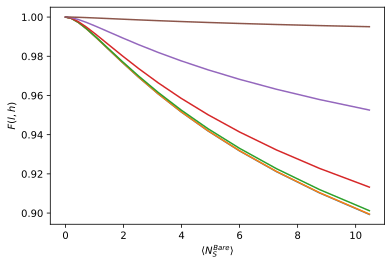

In [9]:
#Plotting the overlaps for different Filters
fig, ax1= plt.subplots()
ax1.plot(nsv, overlap[:,0:6])
ax1.set_ylabel(r"$F(l,h)$")
ax1.set_xlabel(r"$\langle N^{Bare}_{S} \rangle$")
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [05:56<00:00, 23.79s/it]


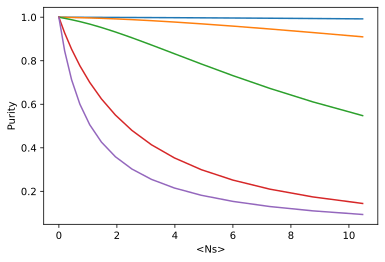

In [10]:
#Loop to calculate purity as a function of gain for certain filter. (Loops over narrowing filters)
pumpscaled=lambda x: pump(x,scale=sc)
npi = 0.00024
npf = 2.068
nstep = 15
step = (npf - npi)/nstep
num_pump = np.arange(npi,npf,step)
Purity = np.zeros([15,5])
nsv = np.zeros_like(num_pump)
for j in range(5):
    for i in tqdm(range(np.size(num_pump))):   
        prod1, P1, Nm1  = Hprop(num_pump[i], vs, vi, vp, dz, x, pumpscaled,4)
        T1 = Total_prog(domain, prod1, P1, Nm1)
        J, Ns, Ks, M, Nums, Numi = JSA(T1, vs, vi, vp, len(domain) * dz, x)
        nsv[i] = Ns
        #Filtering Function
        filt=np.zeros_like(x)
        ind = 30 + 50 * j
        filt[ind:-ind]=1
        filt = np.diag(filt)
        #Filtering out the modes
        M = filt @ M @ filt
        Nums = filt @ Nums @ filt
        Numi = filt @ Numi @ filt
        #Constructing total N and M matrices as well as rotation matrix
        N_tot = np.block([[Nums, 0 * Nums],[0 * Numi, Numi]])
        M_tot = np.block([[0 * M, M],[M.T, 0 * M]])
        R =(1 / np.sqrt(2)) * np.block([[ np.eye(len(N_tot)), 1j * np.eye(len(N_tot))],[np.eye(len(N_tot)), -1j * np.eye(len(N_tot))]])
        #Purity
        V =2 * np.conj(R).T @ (np.block([[N_tot.T, M_tot], [np.conj(M_tot), N_tot]])+np.eye(len(R))/2) @ R
        Purity[i,j] = 1 / np.sqrt(np.real(np.linalg.det(V)))

fig, ax = plt.subplots()
im = ax.plot(nsv, Purity)
ax.set_xlabel("<Ns>")
ax.set_ylabel("Purity")
plt.show()

This next section plots the Schmidt mode for a chosen filter. 

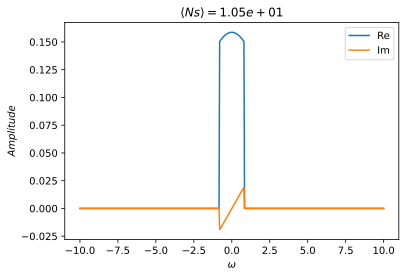

In [11]:
#Plot the different Filtered modes
filt=np.zeros_like(x)
ind = 92 #Choose the width by varying this.
filt[ind:-ind]=1
filt = np.diag(filt)

#filt = np.eye(len(x))   #If you don't want filtering

Mf = filt @ M @ filt
Numsf = filt @ Nums @ filt
Numif = filt @ Numi @ filt


val3, u3 = np.linalg.eigh(Numsf)

fig, ax1 = plt.subplots()

ax1.plot(x, np.real(np.exp(-1j*np.angle(u3[(N-1)//2,-mark]))*u3[:,-mark]), label='Re')
ax1.plot(x, np.imag(np.exp(-1j*np.angle(u3[(N-1)//2,-mark]))*u3[:,-mark]), label='Im')
ax1.set_xlabel(r"$\omega$")
ax1.set_ylabel(r"$Amplitude$")
ax1.set_title(r"$\langle Ns \rangle= %1.2e$" %Ns)
ax1.legend()
plt.show()